In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
ctx = Population(N=1000, tau=1e-2, phi=phi, name='ctx')
bg = Population(N=1000, tau=1e-2, phi=phi, name='bg')
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8) 

S, P = 1, 3
sequences_ctx = [GaussianSequence(P,ctx.size, seed=5) for i in range(S)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])
sequences_bg = [GaussianSequence(P,ctx.size, seed=29) for i in range(S)]
patterns_bg = np.stack([s.inputs for s in sequences_bg])

J_cc = SparseConnectivity(source=ctx, target=ctx, p=0.05)
synapse_cc = LinearSynapse(J_cc.K, A=5)
J_cc.store_attractors(patterns_ctx[0], patterns_ctx[0], synapse_cc.h_EE, 
                      plasticity.f, plasticity.g)
J_bb = SparseConnectivity(source=bg, target=bg, p=0.05)
synapse_bb = LinearSynapse(J_bb.K, A=5)
J_bb.store_attractors(patterns_bg[0], patterns_bg[0], synapse_bb.h_EE, 
                      plasticity.f, plasticity.g)
J_cb  = SparseConnectivity(source=bg, target=ctx, p=0.05)
synapse_cb = LinearSynapse(J_cb.K, A=1)
J_cb.store_attractors(patterns_bg[0], patterns_ctx[0], synapse_cb.h_EE, 
                      plasticity.f, plasticity.g)

J_bc = SparseConnectivity(source=ctx, target=bg, p=0.05)
synapse_bc = LinearSynapse(J_bc.K, A=0)
J_bc.store_sequences(patterns_ctx, patterns_bg, synapse_bc.h_EE, plasticity.f, plasticity.g)
J_bc.update_sequences(patterns_ctx[0][0], patterns_bg[0][1],
                   0.8, lamb=1,f=plasticity.f, g=plasticity.g)
J_bc.update_sequences(patterns_ctx[0][1], patterns_bg[0][2],
                   1, lamb=1,f=plasticity.f, g=plasticity.g)
J_bc.update_sequences(patterns_ctx[0][2], patterns_bg[0][0],
                   0.3, lamb=1,f=plasticity.f, g=plasticity.g)
J_bc.update_sequences(np.random.randn(ctx.size), np.random.randn(bg.size),
                   0.7, lamb=1,f=plasticity.f, g=plasticity.g)
net_ctx = RateNetwork(ctx, c_EE=J_cc, c_IE=J_bc, formulation=4)
net_bg = RateNetwork(bg, c_II=J_bb, c_EI=J_cb, formulation=4)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Storing attractors
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 18756.47it/s]
INFO:connectivity:Building connections from bg to bg
INFO:connectivity:Storing attractors
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 21823.96it/s]
INFO:connectivity:Building connections from bg to ctx
INFO:connectivity:Storing attractors
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 22742.23it/s]
INFO:connectivity:Building connections from ctx to bg
INFO:connectivity:Storing sequences
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.65it/s]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix


In [4]:
init_input_ctx = np.random.RandomState().normal(0,1,size=patterns_ctx[0][0].shape)
init_input_bg = np.random.RandomState().normal(0,1,size=patterns_bg[0][0].shape)
# init_input_ctx = patterns_ctx[0][0]
# init_input_bg = patterns_bg[0][0]
T=10
mouse = ReachingTask(3, alpha=0.5)
net_ctx.simulate_learning(mouse, net_bg, T, init_input_ctx, init_input_bg, 
                          phi(patterns_ctx[0]), phi(patterns_bg[0]), plasticity, detection_thres=.23)

INFO:network:Integrating network dynamics
  1%|▍                                       | 107/9999 [00:02<02:22, 69.47it/s]

null-->aim


  2%|▊                                      | 209/9999 [00:02<01:00, 162.12it/s]

aim-->reach


  5%|█▊                                     | 470/9999 [00:03<00:23, 399.28it/s]

reach-->lick
Mouse received reward


  9%|███▍                                   | 891/9999 [00:04<00:17, 516.64it/s]

lick-->aim


 11%|████▏                                 | 1104/9999 [00:04<00:16, 524.58it/s]

aim-->reach


 14%|█████▏                                | 1370/9999 [00:04<00:16, 525.97it/s]

reach-->lick
Mouse received reward


 18%|██████▊                               | 1795/9999 [00:05<00:15, 519.60it/s]

lick-->aim


 20%|███████▌                              | 2001/9999 [00:06<00:15, 507.85it/s]

aim-->reach


 23%|████████▊                             | 2315/9999 [00:06<00:14, 515.89it/s]

reach-->lick
Mouse received reward


 27%|██████████▍                           | 2743/9999 [00:07<00:13, 526.98it/s]

lick-->aim


 30%|███████████▍                          | 3006/9999 [00:08<00:13, 521.40it/s]

aim-->reach


 32%|████████████▏                         | 3217/9999 [00:08<00:13, 515.87it/s]

reach-->lick
Mouse received reward


 36%|█████████████▊                        | 3637/9999 [00:09<00:12, 522.63it/s]

lick-->aim


 38%|██████████████▋                       | 3849/9999 [00:09<00:11, 518.57it/s]

aim-->reach


 41%|███████████████▋                      | 4114/9999 [00:10<00:11, 523.49it/s]

reach-->lick
Mouse received reward


 45%|█████████████████                     | 4491/9999 [00:10<00:10, 532.66it/s]

lick-->aim


 47%|█████████████████▉                    | 4705/9999 [00:11<00:10, 528.77it/s]

aim-->reach


 49%|██████████████████▋                   | 4917/9999 [00:11<00:09, 525.48it/s]

reach-->lick
Mouse received reward


 53%|████████████████████▎                 | 5349/9999 [00:12<00:08, 527.50it/s]

lick-->aim


 56%|█████████████████████▏                | 5562/9999 [00:12<00:08, 523.36it/s]

aim-->reach


 59%|██████████████████████▎               | 5883/9999 [00:13<00:07, 525.00it/s]

reach-->lick
Mouse received reward


 63%|███████████████████████▊              | 6260/9999 [00:14<00:07, 530.94it/s]

lick-->aim


 65%|████████████████████████▊             | 6526/9999 [00:14<00:06, 524.21it/s]

aim-->reach


 68%|█████████████████████████▊            | 6792/9999 [00:15<00:06, 525.45it/s]

reach-->lick
Mouse received reward


 72%|███████████████████████████▍          | 7222/9999 [00:16<00:05, 533.40it/s]

lick-->aim


 74%|████████████████████████████▎         | 7437/9999 [00:16<00:04, 529.12it/s]

aim-->reach


 77%|█████████████████████████████▎        | 7702/9999 [00:17<00:04, 526.40it/s]

reach-->lick
Mouse received reward


 81%|██████████████████████████████▋       | 8077/9999 [00:17<00:03, 525.66it/s]

lick-->aim


 83%|███████████████████████████████▋      | 8343/9999 [00:18<00:03, 525.13it/s]

aim-->reach


 86%|████████████████████████████████▌     | 8555/9999 [00:18<00:02, 510.46it/s]

reach-->lick
Mouse received reward


 90%|██████████████████████████████████▏   | 8986/9999 [00:19<00:01, 527.55it/s]

lick-->aim


 92%|██████████████████████████████████▉   | 9199/9999 [00:19<00:01, 526.18it/s]

aim-->reach


 95%|███████████████████████████████████▉  | 9466/9999 [00:20<00:01, 528.44it/s]

reach-->lick
Mouse received reward


 98%|█████████████████████████████████████▍| 9843/9999 [00:21<00:00, 532.15it/s]

lick-->aim


100%|█████████████████████████████████████▊| 9950/9999 [00:21<00:00, 528.34it/s]

In [5]:
overlaps_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi)
# correlations_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi, correlation=True)
overlaps_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi)
# correlations_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi, correlation=True)

INFO:sequences:Computing overlaps

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 253.27it/s]
INFO:sequences:Computing overlaps

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 323.10it/s]


In [6]:
sns.set_style('dark') 
plt.rcParams["font.family"] = "arial"
colors = sns.color_palette('deep')

100%|██████████████████████████████████████| 9999/9999 [00:21<00:00, 459.03it/s]


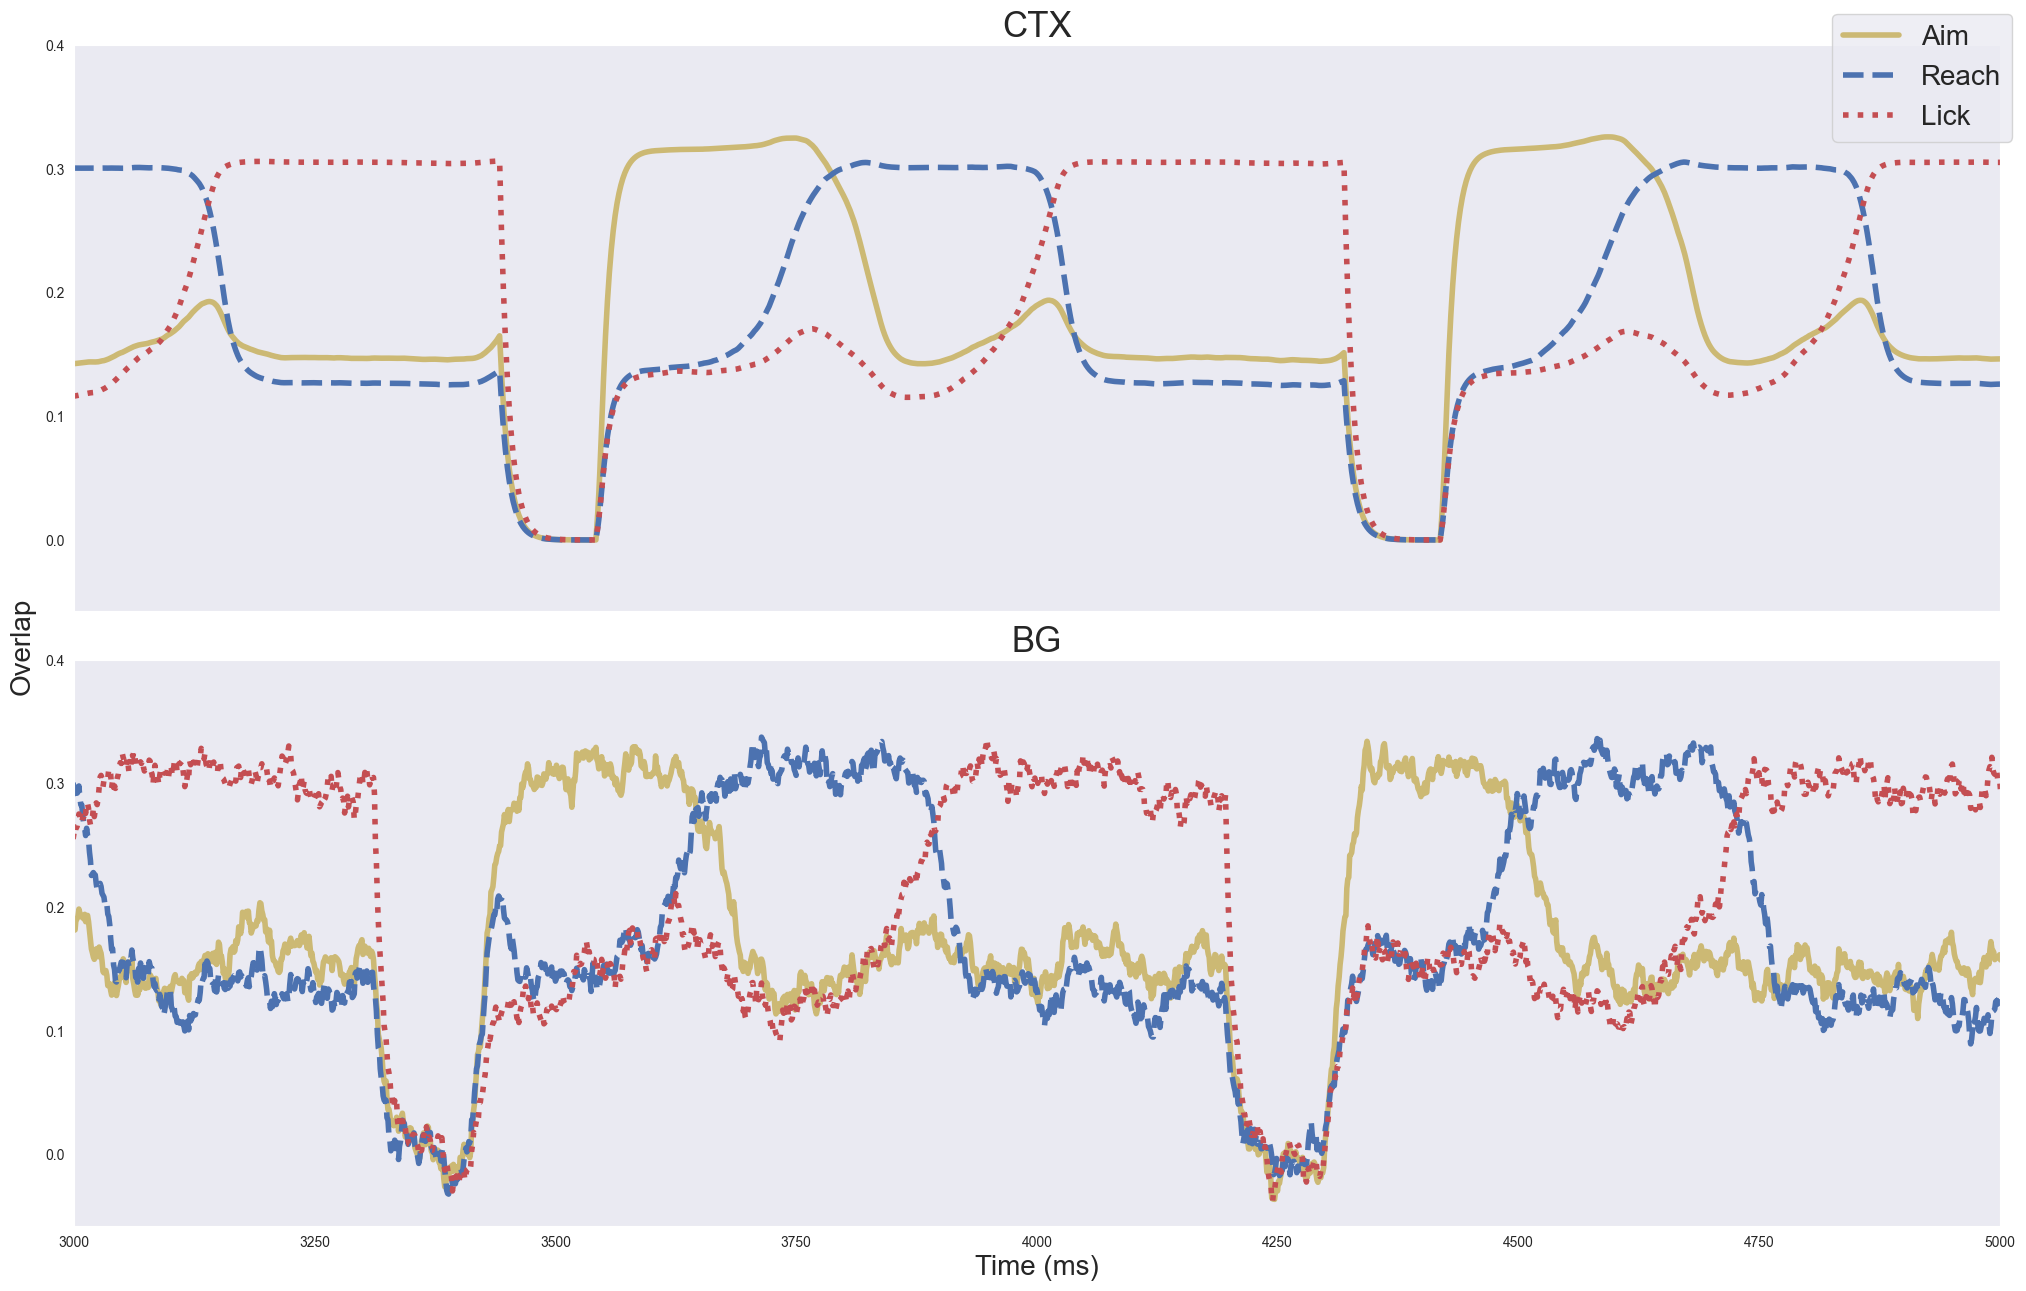

In [7]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=4, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_bg[0], linestyle='solid', linewidth=4, color=colors[8])
axes[1].plot(overlaps_bg[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[1].plot(overlaps_bg[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("BG", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(3000, 5000))
plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.show()


In [8]:
mouse.calibrate()

ValueError: operands could not be broadcast together with shapes (52,) (46,) 

In [ ]:
np.savez('./output/test.npz', overlaps_ctx=overlaps_ctx, overlaps_bg=overlaps_bg)